In [150]:
import numpy as np
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import pickle
import yaml

from matplotlib import rcParams
rcParams["legend.frameon"] = False
from mpl_toolkits.mplot3d import Axes3D


with open('save_path.yaml') as f:
    save_paths = yaml.load(f)

data_folder_base  = os.path.join(save_paths.get('data_path',''))

## Set up filenames

In [157]:
file_select = 'harder'
number_of_markers = 2

save_pickles = True
save_csvs    = True

if file_select == 'hard':
    file_names = ['ihm_rot_gait_foam_3_Trajectories_500']
    
elif file_select == 'harder':
    file_names = ['ihm_rot_gait_box_3_Trajectories_500']
    
elif file_select == 'easy':
    file_names = ['ihm_rot_gait_yellowcup_Trajectories_500',
                  'ihm_rot_gait_orangecup2_Trajectories_500']
    
elif file_select == 'incept':
    file_names = ['ihm_rot_gait_foam_3_Trajectories_500_fixed']
    
else:
    file_names = []

    
vicon_sample_rate = 500 # Hz
vicon_units = 'mm/10' # 'mm' or 'mm/10'

## Define some functions

In [158]:
# Pickle the data for future use.
def pickle_data(out_data, filename):
    out_file = os.path.join(data_folder_base,filename+'_fixed.pkl')

    dirname = os.path.dirname(out_file)
    if not os.path.exists(dirname):
        os.makedirs(dirname)

    print("")
    print("Pickling...")
    print('file: %s'%(filename))
    with open(out_file, 'w') as f:
        pickle.dump(out_data, f)
    print("Pickling...DONE!")
            
            
def save_csv(out_data_all_in_one, filename, header=None):
    out_file = os.path.join(data_folder_base,filename+'_fixed.csv')

    dirname = os.path.dirname(out_file)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    
    print("")
    print("Saving CSV...")
    print('file: %s'%(filename))
    with open(out_file, 'w') as f:
        if header is not None:
            f.write(header+'\n')
        np.savetxt(f, out_data_all_in_one, delimiter=',')
    print("Saving CSV...DONE!")
        
        
def plot_all(data_collapsed,file_idx,number_of_markers):
    # plot the points in 3D and in 2D
    fig = plt.figure(1+file_idx*2)
    ax = fig.add_subplot(111, projection='3d')

    for mark_idx in range(number_of_markers):
        ax.plot(data_collapsed[:,0+mark_idx*3],
                 data_collapsed[:,1+mark_idx*3],
                 data_collapsed[:,2+mark_idx*3])
    plt.show()

    fig2 = plt.figure(2+file_idx*2)
    plt.plot(data_collapsed)
    plt.show()

In [159]:
def fix_sequential(pos, number_of_markers):
    pos_fix=np.zeros(pos.shape)

    pos_fix[0,:] = pos[0,:]

    for idx, curr_row in enumerate(pos[1:,:]):
        idx +=1
        last_row = pos_fix[idx-1,:]

        # for every point in the current row, find the norm with all points from the last row
        correct_idx = np.zeros((number_of_markers,1))
        for i in range(number_of_markers):
            norm = np.zeros((number_of_markers,1))
            curr_pt = curr_row[i*3: i*3 +3]
            #print(curr_pt)
            # for each point in the last row, find the norm with the current point
            for j in range(number_of_markers):
                #print(last_row[j*3: j*3 +3])
                diff= curr_pt - last_row[j*3: j*3 +3]
                norm[j] = np.linalg.norm(diff)

            correct_idx[i]=np.argmin(norm)

        new_idx = [0,1,2]+correct_idx*3
        new_idx = new_idx.ravel().astype(int)
        curr_row = curr_row[new_idx]

        pos_fix[idx,:] = curr_row

    #plot_all(pos_fix,3,number_of_markers)
    
    return pos_fix

def fix_units(input_units, desired_units):
    if input_units == desired_units:
        return 1.0
    else
        if input_units = 'mm/10' and desired_units == 'mm':
            return 0.1
        elif input_units = 'mm' and desired_units == 'mm/10'
            return 10
        

## Read in the data

In [160]:
raw_data_all = []
for file_name in file_names:
    full_filename = os.path.join(data_folder_base,file_name+'.csv')
    with open(full_filename) as f:
        # this is probably the stupidest way to load the data,
        # since sometimes when markers are blinking  we get a HUGE matrix
        raw_data = np.genfromtxt(f, skip_header=5, delimiter=',')
        raw_data
    
    print(raw_data.shape)
    print(raw_data[0,:])
    raw_data_all.append(raw_data)

(94415L, 3968L)
[   1.       0.     214.057 ...,      nan      nan      nan]


## Get rid of 'nan' and match up columns


ihm_rot_gait_box_3_Trajectories_500
There are 1322 tracking columns from vicon to deal with

Deleted 1414 frames, which is 1.498% of all data
Merged 0 frames, which is 0.000% of all data

Fixing sequential data jumping issues

Time: 0.000 sec to 188.828 sec
      0.000 min to 3.147 min


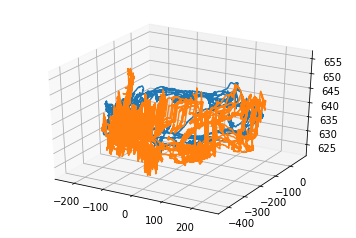

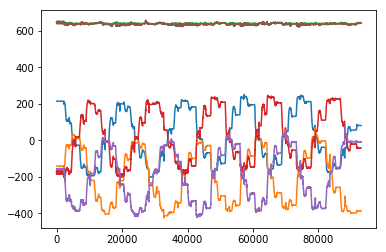


Pickling...
file: ihm_rot_gait_box_3_Trajectories_500
Pickling...DONE!

Saving CSV...
file: ihm_rot_gait_box_3_Trajectories_500
Saving CSV...DONE!


In [161]:
all_data_out = []

unit_multiplier = fix_units(vicon_units, 'mm')

for file_idx, curr_raw_data in enumerate(raw_data_all):
    print("")
    print(file_names[file_idx])
    data = curr_raw_data[:,2:]*unit_multiplier
    frame_numbers = curr_raw_data[:,0]
    time = (frame_numbers-1)*1.0/vicon_sample_rate
    
    not_divisible_by_3 = np.mod(data.shape[1],3)
    if not_divisible_by_3:
        print("The number of columns isn't divisible by 3. Are you missing an axis???")
    
    else:
        num_points = data.shape[1]/3.0
        num_point_cols = number_of_markers*3
        
        frames_to_skip = []
        num_merged_frames  = 0
        
        print("There are %d tracking columns from vicon to deal with"%(num_points))
        
        data_collapsed=np.zeros((data.shape[0],3*number_of_markers))
        for idx,row in enumerate(np.nditer(data, flags=['external_loop'], order='C')):
            row_collapsed = row[np.logical_not(np.isnan(row))]
            
            # If the number of points in the frame matches what we expect, use them!
            if row_collapsed.size == num_point_cols: 
                data_collapsed[idx,:] = row_collapsed
                            
            # If there are too many points in a frame,
            # find the closest N points to the previous frame
            elif  row_collapsed.size > num_point_cols:
                frames_to_skip.append(idx) # This is temporary
                
            # If there are too few points in the frame, delete the frame.
            else:
                frames_to_skip.append(idx)
        
        # Delete frames that need to be deleted
        data_collapsed   = np.delete(data_collapsed, frames_to_skip, 0)
        frames_collapsed = np.delete(frame_numbers, frames_to_skip, 0)
        time_collapsed   = np.delete(time, frames_to_skip, 0)
        
        # Print out some statistics
        skip_percent = float(len(frames_to_skip))/data.shape[0]*100
        merge_percent = float(num_merged_frames)/data.shape[0]*100
        print("")
        print("Deleted %d frames, which is %0.3f"%(len(frames_to_skip), skip_percent)+"% of all data")
        print("Merged %d frames, which is %0.3f"%(num_merged_frames, merge_percent)+"% of all data")

        # Fix sequential data points to make sure they don't jump around
        print("")
        print('Fixing sequential data jumping issues')
        data_collapsed = fix_sequential(data_collapsed, number_of_markers)
        
        # Package the data in a native python dictionary for use later
        out = dict()
        out['position']=data_collapsed.tolist()
        out['frame']=frames_collapsed.tolist()
        out['time']=time_collapsed.tolist()
        out['num_frames']=frames_collapsed.size
        out['start_time']=time_collapsed[0]
        out['end_time']=time_collapsed[-1]
        
                
        print("")
        print("Time: %0.3f sec to %0.3f sec"%(out['start_time'],out['end_time']))
        print("      %0.3f min to %0.3f min"%(out['start_time']/60.0,out['end_time']/60.0))
                
        plot_all(data_collapsed,file_idx,number_of_markers)
        file_name_out = file_names[file_idx]
        # Pickle the data for use later
        if save_pickles:
            pickle_data(out, file_name_out)
        
        if save_csvs:
            all_in_one = data_collapsed
            all_in_one = np.insert(all_in_one,0,time_collapsed, axis=1)
            all_in_one = np.insert(all_in_one,0,frames_collapsed, axis=1)

            header = '\n'*4
            header += 'Frame,Time'
            for i in range(number_of_markers):
                header+=",X%d,Y%d,Z%d"%(i,i,i)
            save_csv(all_in_one, file_name_out, header = header)
        
    